In [103]:
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

In [4]:
from pocovidnet.evaluate_covid19 import Evaluator

In [223]:
# MC Dropout

passes = 10
saved_logits, saved_gt, saved_files = [], [], []
mc_stds = []
for i in range(5):
    print("------------- SPLIT ", i, "-------------------")
    # define data input path
    path = "../../data/cross_validation/split"+str(i)
    
    train_labels, test_labels, test_files = [], [], []
    train_data, test_data = [], []

    # loop over the image paths (train and test)
    for imagePath in paths.list_images(path):

        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        test_labels.append(label)
        test_data.append(image)
        test_files.append(imagePath.split(os.path.sep)[-1])

    # build ground truth data
    classes = ["covid", "pneumonia", "regular", 'uninformative']
    gt_class_idx = np.array([classes.index(lab) for lab in test_labels])
    
    # load model
    model = Evaluator(ensemble=False, split=i, model_id='vgg_base', num_classes=len(classes), mc_dropout=True)
    print(model.models)
    
    # MAIN STEP: feed through model and compute logits
    logits = np.zeros((len(test_data), len(classes)))
    all_class_stds = np.zeros((len(test_data), len(classes)))
    for img_idx, img in enumerate(test_data):
        raw_logits = np.zeros((passes, len(classes)))
        for idx in range(10):
            raw_logits[idx, :] = model(img)
        logits[img_idx, :] = np.mean(raw_logits, axis=0)
        all_class_stds[img_idx, :] = np.std(raw_logits, axis=0)
        
            
#     logits = np.array([model(img) for img in test_data])
    print(logits.shape)
    
    # remember for evaluation:
    saved_logits.append(logits)
    saved_gt.append(gt_class_idx)
    saved_files.append(test_files)

    
    # output the information
    predIdxs = np.argmax(logits, axis=1)
    
    stds = np.array([all_class_stds[c, idx] for c,idx in enumerate(predIdxs)])
    mc_stds.append(stds)
    
    print(
    classification_report(
        gt_class_idx, predIdxs, target_names=classes
        )
    )


------------- SPLIT  0 -------------------
Model restored. Class mappings are ['covid', 'pneunomia', 'regular', 'uninformative']
(359, 4)
               precision    recall  f1-score   support

        covid       0.87      0.85      0.86       112
    pneumonia       0.83      0.85      0.84        85
      regular       0.96      0.99      0.98        82
uninformative       1.00      0.99      0.99        80

     accuracy                           0.91       359
    macro avg       0.92      0.92      0.92       359
 weighted avg       0.91      0.91      0.91       359

------------- SPLIT  1 -------------------
Model restored. Class mappings are ['covid', 'pneunomia', 'regular', 'uninformative']
(384, 4)
               precision    recall  f1-score   support

        covid       0.99      0.86      0.92       197
    pneumonia       0.90      1.00      0.94        60
      regular       0.68      0.96      0.80        47
uninformative       1.00      0.99      0.99        80

    

In [93]:
def confidence_to_precision(x):
    return -(x-0.)/(0.5-0)+1

In [113]:
mc_drop = np.clip(np.concatenate(mc_stds), 0, 0.5)
gts = np.concatenate(saved_gt)
preds = np.concatenate([np.argmax(sl, axis=1) for sl in saved_logits])
correct = (gts == preds).astype(int)

mc_precision = np.array(list(map(confidence_to_precision,mc_drop)))

Text(0.5, 1.0, 'MC Dropout')

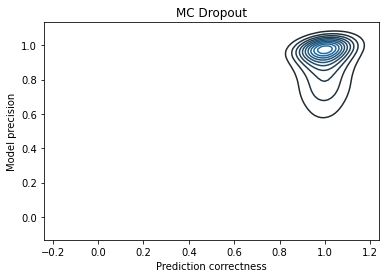

In [114]:
sns.kdeplot(correct, mc_precision)
plt.xlabel('Prediction correctness')
plt.ylabel('Model precision')
plt.title('MC Dropout')


In [115]:
pearsonr(mc_precision,correct)

(0.25424626303289327, 1.937930878831481e-27)

In [129]:
correct_idx = correct.astype(bool)
print(np.mean(mc_precision[correct_idx]))
print(np.mean(mc_precision[~correct_idx]))
print(np.std(mc_precision[correct_idx]))
print(np.std(mc_precision[~correct_idx]))

0.877740376249769
0.7355829741518711
0.1439326481151392
0.1962255018146544


In [131]:
np.save('/Users/jab/codevscovid/covid_detector/covid19_pocus_ultrasound/analysis/mc_confidence.npy', mc_precision)

In [136]:
# Test time augmentation

passes = 10
saved_logits_tta, saved_gt, saved_files = [], [], []
mc_stds = []
for i in range(5):
    print("------------- SPLIT ", i, "-------------------")
    # define data input path
    path = "../../data/cross_validation/split"+str(i)
    
    train_labels, test_labels, test_files = [], [], []
    train_data, test_data = [], []

    # loop over the image paths (train and test)
    for imagePath in paths.list_images(path):

        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        test_labels.append(label)
        test_data.append(image)
        test_files.append(imagePath.split(os.path.sep)[-1])

    # build ground truth data
    classes = ["covid", "pneumonia", "regular", 'uninformative']
    gt_class_idx = np.array([classes.index(lab) for lab in test_labels])
    
    # load model
    model = Evaluator(ensemble=False, split=i, model_id='vgg_base', num_classes=len(classes), mc_dropout=False)
    print(model.models)
    
    # MAIN STEP: feed through model and compute logits
    logits = np.zeros((len(test_data), len(classes)))
    all_class_stds = np.zeros((len(test_data), len(classes)))
    for img_idx, img in enumerate(test_data):
        raw_logits = np.zeros((passes, len(classes)))
        for idx in range(10):
            raw_logits[idx, :] = model(img, augment=True)
        logits[img_idx, :] = np.mean(raw_logits, axis=0)
        all_class_stds[img_idx, :] = np.std(raw_logits, axis=0)
        
            
#     logits = np.array([model(img) for img in test_data])
    print(logits.shape)
    
    # remember for evaluation:
    saved_logits_tta.append(logits)
    saved_gt.append(gt_class_idx)
    saved_files.append(test_files)

    
    # output the information
    predIdxs = np.argmax(logits, axis=1)
    
    stds = np.array([all_class_stds[c, idx] for c,idx in enumerate(predIdxs)])
    mc_stds.append(stds)
    
    print(
    classification_report(
        gt_class_idx, predIdxs, target_names=classes
        )
    )


------------- SPLIT  0 -------------------
Model restored. Class mappings are ['covid', 'pneunomia', 'regular', 'uninformative']
(359, 4)
               precision    recall  f1-score   support

        covid       0.94      0.96      0.95       112
    pneumonia       0.95      0.92      0.93        85
      regular       0.99      0.99      0.99        82
uninformative       1.00      1.00      1.00        80

     accuracy                           0.97       359
    macro avg       0.97      0.97      0.97       359
 weighted avg       0.97      0.97      0.97       359

------------- SPLIT  1 -------------------
Model restored. Class mappings are ['covid', 'pneunomia', 'regular', 'uninformative']
(384, 4)
               precision    recall  f1-score   support

        covid       0.96      0.85      0.90       197
    pneumonia       0.92      1.00      0.96        60
      regular       0.62      0.85      0.72        47
uninformative       1.00      1.00      1.00        80

    

In [203]:
from collections import Counter
gts = np.concatenate(saved_gt)

preds = np.concatenate([np.argmax(sl, axis=1) for sl in saved_logits_tta])
# preds = np.array([pred for gt,pred in zip(gts,preds) if gt!=3])

ttas = np.clip(np.concatenate(mc_stds), 0, 0.5)
# ttas = np.array([tta for gt,tta in zip(gts,ttas) if gt!=3])

tta_precision = np.array(list(map(confidence_to_precision,ttas)))
# gts = np.array([gt for gt in gts if gt !=3])

correct = (gts == preds).astype(int)



Text(0.5, 1.0, 'Test time augmentation')

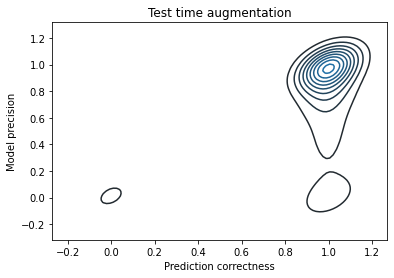

In [204]:
sns.kdeplot(correct, tta_precision)
plt.xlabel('Prediction correctness')
plt.ylabel('Model precision')
plt.title('Test time augmentation')


In [213]:
pearsonr(tta_precision,correct)

(0.4115532607096564, 4.1508125942505177e-73)

In [214]:
pearsonr(mc_precision,correct)

(0.287637983116663, 5.703629789736473e-35)

In [215]:
pearsonr(tta_precision,mc_precision)

(0.5224457774194512, 3.3820932282124883e-124)

In [216]:
correct_idx = correct.astype(bool)
print(np.mean(tta_precision[correct_idx]))
print(np.mean(tta_precision[~correct_idx]))
print(np.std(tta_precision[correct_idx]))
print(np.std(tta_precision[~correct_idx]))
np.mean(tta_precision)

0.7524914023823827
0.2672991290722443
0.33310918416226326
0.3527499573591399


0.6994363832612174

In [217]:
correct_idx = correct.astype(bool)
print(np.mean(mc_precision[correct_idx]))
print(np.mean(mc_precision[~correct_idx]))
print(np.std(mc_precision[correct_idx]))
print(np.std(mc_precision[~correct_idx]))
np.mean(mc_precision)

0.8815039303084143
0.7395471758016691
0.14358148555789807
0.17626614934737098


0.8659811803821811

In [220]:
conf_mean = np.mean([mc_precision, tta_precision],axis=0)
print(np.mean(conf_mean[correct_idx]))
print(np.mean(conf_mean[~correct_idx]))
print(np.std(conf_mean[correct_idx]))
print(np.std(conf_mean[~correct_idx]))
np.mean(conf_mean)

0.8169976663453985
0.5034231524369566
0.2101490359665522
0.2275750846374994


0.7827087818216991

In [218]:
data = np.array([correct, mc_precision, tta_precision])

In [156]:
pd.DataFrame(data).T.corr()

,0,1,2
0,1.000000,0.287638,0.411553
1,0.287638,1.000000,0.522446
2,0.411553,0.522446,1.000000


In [159]:
filtered_preds = []
filtered_gt = []

for pred, gt, tta in zip(preds, gts, tta_precision):
    if tta > 0.5:
        filtered_preds.append(pred)
        filtered_gt.append(gt)


In [163]:
report = classification_report(
    gts, preds, target_names=classes, output_dict=True
    )

In [169]:
for key, value in report.items():
    print(key, value)

covid {'precision': 0.8380187416331994, 'recall': 0.9033189033189033, 'f1-score': 0.8694444444444444, 'support': 693}
pneumonia {'precision': 0.9487951807228916, 'recall': 0.8355437665782494, 'f1-score': 0.8885754583921015, 'support': 377}
regular {'precision': 0.8118466898954704, 'recall': 0.7898305084745763, 'f1-score': 0.8006872852233677, 'support': 295}
uninformative {'precision': 0.9974937343358395, 'recall': 0.995, 'f1-score': 0.9962453066332916, 'support': 400}
accuracy 0.8906515580736544
macro avg {'precision': 0.8990385866468502, 'recall': 0.8809232945929322, 'f1-score': 0.8887381236733013, 'support': 1765}
weighted avg {'precision': 0.8934476137891428, 'recall': 0.8906515580736544, 'f1-score': 0.8907755351886869, 'support': 1765}


In [170]:
report = classification_report(
    filtered_gt, filtered_preds, target_names=classes, output_dict=True
    )

In [189]:
thresh=-1
filtered_preds = []
filtered_gt = []

for pred, gt, tta in zip(preds, gts, tta_precision):
    if tta > thresh:
        filtered_preds.append(pred)
        filtered_gt.append(gt)
print(len(filtered_preds), ' out of ', len(preds))
report = classification_report(
    filtered_gt, filtered_preds, target_names=classes, output_dict=True
    )

for key, value in report.items():
    print(key, value)

1765  out of  1765
covid {'precision': 0.8380187416331994, 'recall': 0.9033189033189033, 'f1-score': 0.8694444444444444, 'support': 693}
pneumonia {'precision': 0.9487951807228916, 'recall': 0.8355437665782494, 'f1-score': 0.8885754583921015, 'support': 377}
regular {'precision': 0.8118466898954704, 'recall': 0.7898305084745763, 'f1-score': 0.8006872852233677, 'support': 295}
uninformative {'precision': 0.9974937343358395, 'recall': 0.995, 'f1-score': 0.9962453066332916, 'support': 400}
accuracy 0.8906515580736544
macro avg {'precision': 0.8990385866468502, 'recall': 0.8809232945929322, 'f1-score': 0.8887381236733013, 'support': 1765}
weighted avg {'precision': 0.8934476137891428, 'recall': 0.8906515580736544, 'f1-score': 0.8907755351886869, 'support': 1765}


In [225]:
a=np.array([3])
b=np.array([1,2])


In [236]:
import glob

In [237]:
for filename in glob.glob('../'):
    print(filename)

../


In [247]:
from pathlib import Path

for p in Path('../').glob('*/*'):
    print(p)

../bin/covidnet.sh
../bin/run_cross_val.sh
../bin/output
../bin/run_cv_efficientnet.sh
../models/.DS_Store
../models/NasNet_F
../models/NasNet_B
../models/deprecated
../trained_models/fold_4
../trained_models/fold_3
../trained_models/fold_2
../trained_models/.DS_Store
../trained_models/org
../trained_models/README.md
../trained_models/fold_0
../trained_models/fold_1
../trained_models/trained_models_gradcam
../trained_models/git_models
../trained_models/trained_models_cam
../pocovidnet.egg-info/PKG-INFO
../pocovidnet.egg-info/not-zip-safe
../pocovidnet.egg-info/SOURCES.txt
../pocovidnet.egg-info/requires.txt
../pocovidnet.egg-info/top_level.txt
../pocovidnet.egg-info/dependency_links.txt
../scripts/cross_val_splitter.py
../scripts/add_uninformative_class.py
../scripts/build_image_dataset.py
../scripts/video_classification.py
../scripts/__pycache__
../scripts/train_covid19.py
../scripts/eval_vid_classifier.py
../scripts/process_butterfly_videos.py
../scripts/process_butterfly_data.py
../

In [256]:
!ls

VideosToImages.ipynb               t.npz
class_activation_maps.ipynb        test_z0.4_hw_0.4_class_1_mid_0.png
cross_validation.ipynb             uncertainity_estimates.ipynb
crossval_evaluate.ipynb            uninformative_class.ipynb
eval_cams.ipynb                    video_classifier.ipynb
heatmap.ipynb                      video_script.ipynb


In [433]:
np.concatenate([np.array([1,2,3])])

array([1, 2, 3])

In [265]:
p = '/Users/jab/codevscovid/covid_detector/covid19_pocus_ultrasound/data/cv_iclus/split0/covid/Cov-Atlas-Day+2.gif_frame9.jpg.npz'

d = np.load(p)



In [362]:
for k in d.keys():
    print(k,d[k].shape)
    print()
    
print(d['f3'][0,:,:,:].shape)
f3 = cv2.resize(d['f3'][0,:,:,:], (7,9))
print(f3.shape)

f1 (1, 10, 13, 64)

f2 (1, 7, 9, 256)

f3 (1, 25, 33, 320)

(25, 33, 320)
(9, 7, 320)


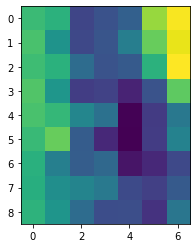

In [363]:
plt.imshow(f3[:,:,32])

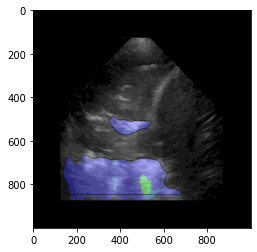

In [308]:
p = '/Users/jab/codevscovid/covid_detector/iclus_model/Outputs/split4/pneumonia/pneu-gred-6.gif_frame8.jpg.gif'
cap = cv2.VideoCapture(p)

ret, image = cap.read()
plt.imshow(image)


In [310]:
image.shape
ref = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ref = cv2.resize(image, (224,224))
ref.shape

(224, 224, 3)

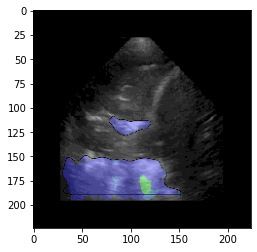

In [312]:
plt.imshow(ref)

In [324]:
ref[160:170, 100:110,0]

array([[103, 103, 103, 113, 120, 135, 135, 135, 135, 138],
       [103, 103, 103, 103, 120, 135, 135, 135, 135, 135],
       [103, 103, 120, 120, 135, 135, 135, 135, 135, 135],
       [103, 120, 120, 120, 135, 135, 135, 135, 145, 153],
       [103, 103, 103, 103, 120, 113, 120, 120, 120, 138],
       [ 98, 103, 103, 103, 120, 125, 125, 115, 120, 123],
       [ 89,  89,  89, 103, 103, 120, 120, 120, 120, 120],
       [ 89,  89, 103, 103, 103, 103, 103, 113, 103, 118],
       [ 81,  89,  89, 103, 103, 103, 103, 103, 103, 115],
       [ 89,  89,  89,  89, 103, 100, 103, 103, 103, 107]], dtype=uint8)

In [313]:
imagePath = '/Users/jab/codevscovid/covid_detector/covid19_pocus_ultrasound/data/cross_validation/split1/pneumonia/Pneu-grep-bacterial-hepatization-clinical.mp4_frame8.jpg'


image = cv2.imread(imagePath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224,224))

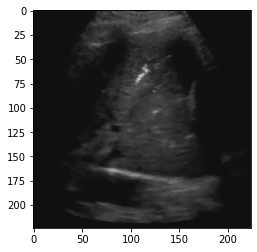

In [315]:
plt.imshow(image)

In [325]:
from imutils import paths

In [328]:
help(paths.list_files)

Help on function list_files in module imutils.paths:

list_files(basePath, validExts=None, contains=None)



In [439]:
np.mean([0.92045,
0.95833,
0.88415,
0.91964,
0.96307])

0.9291280000000001

In [1]:
import pandas as pd

df = pd.read_csv('/Users/jab/codevscovid/covid_detector/XX/results_segmented.csv')

df

FileNotFoundError: [Errno 2] File /Users/jab/codevscovid/covid_detector/XX/results_segmented.csv does not exist: '/Users/jab/codevscovid/covid_detector/XX/results_segmented.csv'

In [484]:
names = []
perfs = []
folds = []
params = []
for i,row in df.iterrows():
    for index in row.index:
        
        if index.startswith('fold'):
            num_p = int(row['params'].replace('.',''))
            folds.append(index[-1])
            names.append(row['name'])
            perfs.append(row[index])
            params.append(num_p)


In [485]:
res = pd.DataFrame({
    'model': names,
    'fold': folds,
    'acc': perfs,
    'parameter':params
    
})

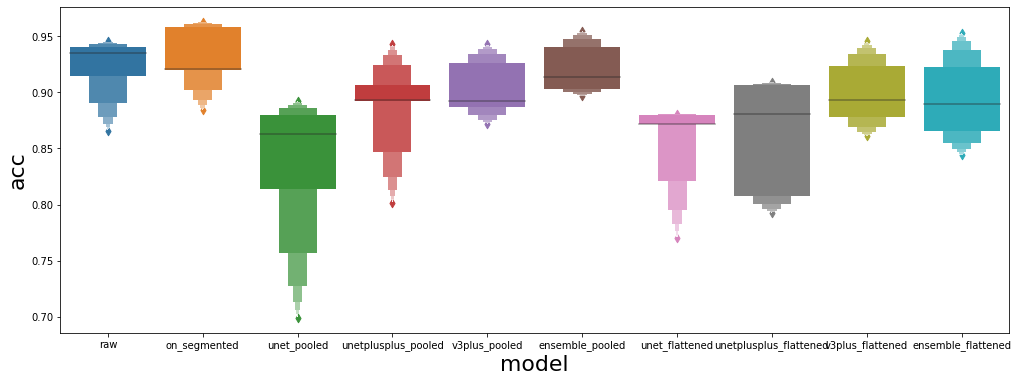

In [477]:
plt.figure(figsize=(17,6))
plt.xlabel('Model', size=22)
plt.ylabel('Accuracy', size=22)
sns.boxenplot(x='model', y='acc', data=res)

In [472]:
df.mean(axis=1)

0    0.920214
1    0.929128
2    0.829648
3    0.887140
4    0.903950
5    0.921618
6    0.854950
7    0.859366
8    0.900118
9    0.894908
dtype: float64

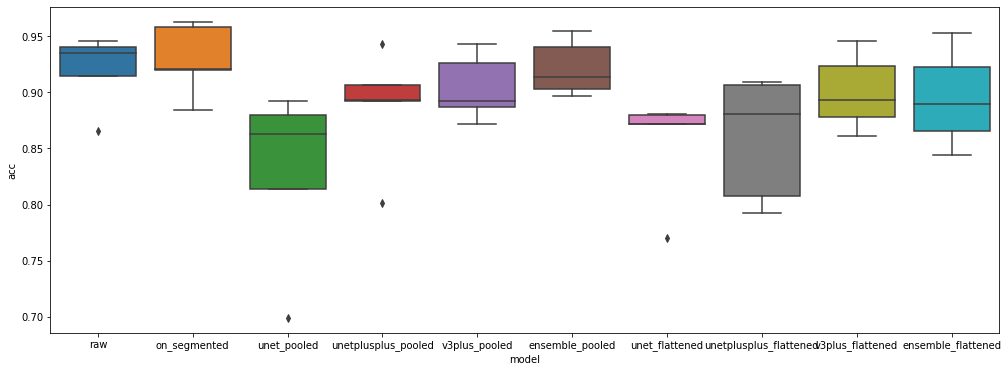

In [471]:
plt.figure(figsize=(17,6))

sns.boxplot(x='model', y='acc', data=res)

In [1]:
from pocovidnet.model import get_dense_model

In [19]:
model = get_dense_model(input_size=640, hidden_sizes=[512,256], batch_norm=True)


model.load_weights('/Users/jab/Downloads/_fold_0/fold_0_epoch_02/variables/variables')

In [17]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 640)]             0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               328192    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0  